In [1]:
from scipy.stats import chi2, expon, weibull_min
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from copy import deepcopy
import os

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import nflows
from nflows import flows, transforms
from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.nn.nets import ResidualNet

np.random.seed(100)
print(torch.cuda.is_available())

True


In [2]:
print(torch.cuda.current_device())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

0
cuda


In [3]:
class MyDataset(Dataset):
    def __init__(
        self,
        dataframe,
        context_variables,
        target_variables,
        device=None,
        rows=None,
    ):
        self.context_variables = context_variables
        self.target_variables = target_variables
        self.all_variables = context_variables + target_variables
        data = dataframe
        if rows is not None:
            data = data.iloc[:rows]
        self.target = data[target_variables].values
        self.context = data[context_variables].values
        self.weights = data[['weight']].values
        if device is not None:
            self.target = torch.tensor(self.target, dtype=torch.float32).to(device)
            self.context = torch.tensor(self.context, dtype=torch.float32).to(device)
            self.weights = torch.tensor(self.weights, dtype=torch.float32).to(device)

    def __len__(self):
        assert len(self.context) == len(self.target)
        return len(self.target)

    def __getitem__(self, idx):
        return self.context[idx], self.target[idx], self.weights[idx]

In [4]:
input_dir = "./samples"
df = pd.read_parquet(os.path.join(input_dir, "train.parquet"))
df_target = pd.read_parquet(os.path.join(input_dir, "train_target.parquet"))
df_test = pd.read_parquet(os.path.join(input_dir, "test.parquet"))
df_target_test = pd.read_parquet(os.path.join(input_dir, "test_target.parquet"))

In [5]:
df['lab'] = 1
df_test['lab'] = 1
df_target['lab'] = 0
df_target_test['lab'] = 0

In [6]:
new_df_train = pd.concat([df, df_target])
new_df_train = new_df_train.reset_index(drop=True)
new_df_train = new_df_train.sample(frac=1).reset_index(drop=True)
new_df_test = pd.concat([df_test, df_target_test])
new_df_test = new_df_test.reset_index(drop=True)
new_df_test = new_df_test.sample(frac=1).reset_index(drop=True)

In [7]:
context_vars = ['a', 'b', 'lab']
input_vars = ['x', 'y']
rows = 200000
rows_test = 100000
batch_size = 1000
print(len(new_df_train), len(new_df_test))

new_dataset_train = MyDataset(new_df_train, context_vars, input_vars, device=device, rows=rows)
new_loader_train = DataLoader(new_dataset_train, batch_size=batch_size)
new_dataset_test = MyDataset(new_df_test, context_vars, input_vars, device=device, rows=rows)
new_loader_test = DataLoader(new_dataset_test, batch_size=batch_size)

2800000 1200000


In [8]:
def apply(flow, df_mc, df_data):
    abl = torch.tensor(df_mc[['a', 'b', 'lab']].values, dtype=torch.float32).to(device)
    xy_uncorr = torch.tensor(df_mc[['x', 'y']].values, dtype=torch.float32).to(device)
    xy_uncorr_latent = flow._transform(xy_uncorr, abl)[0]
    x_uncorr_latent, y_uncorr_latent = xy_uncorr_latent[:, 0].detach().cpu().numpy(), xy_uncorr_latent[:, 1].detach().cpu().numpy()
    x_uncorr, y_uncorr = xy_uncorr[:, 0].detach().cpu().numpy(), xy_uncorr[:, 1].detach().cpu().numpy()
    #weights = torch.tensor(df_mc['weight'].values).to(device)
    
    # second part of transformation
    zeros = torch.zeros(xy_uncorr_latent.shape[0], 1).to(device)
    ab = torch.tensor(df_mc[['a', 'b']].values, dtype=torch.float32).to(device)
    abl = torch.cat((ab, zeros), axis=1)
    xy_corr = flow._transform.inverse(xy_uncorr_latent, abl)[0]
    x_corr, y_corr = xy_corr[:, 0].detach().cpu().numpy(), xy_corr[:, 1].detach().cpu().numpy()
    
    # get from data
    x_data, y_data = df_data[['x']].values, df_data[['y']].values
    
    #weights = weights.detach().cpu().values
    weights = df_mc['weight'].values
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    ax1.hist(x_uncorr_latent, bins=100, density=True, label='latent', weights=weights)
    ax1.set_xlabel('x')
    ax1.legend()
    ax2.hist(y_uncorr_latent, bins=100, density=True, label='latent', weights=weights)
    ax2.set_xlabel('y')
    ax2.legend()
    plt.show()
    """
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    ax1.hist(x_uncorr, bins=100, density=True, label='uncorr', weights=weights)
    ax1.hist(x_data, bins=100, density=True, label='data')
    ax1.hist(x_corr, bins=100, density=True, label='corr', alpha=0.5, weights=weights)
    ax1.set_xlabel('x')
    ax1.legend()
    ax2.hist(y_uncorr, bins=100, density=True, label='uncorr', weights=weights)
    ax2.hist(y_data, bins=100, density=True, label='data')
    ax2.hist(y_corr, bins=100, density=True, label='corr', alpha=0.5, weights=weights)
    ax2.set_xlabel('y')
    ax2.legend()
    plt.show()

In [9]:
ninput = 2
ncontext = 3

epochs = 30
plot_every = 10

def spline_inn(
    inp_dim,
    nodes=128,
    num_blocks=2,
    num_stack=3,
    tail_bound=3.5,
    tails="linear",
    activation=F.relu,
    lu=0,
    num_bins=12,
    context_features=None,
    dropout_probability=0.0,
    flow_for_flow=False,
):
    transform_list = []
    for i in range(num_stack):
        transform_list += [
            transforms.MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
                inp_dim,
                nodes,
                num_blocks=num_blocks,
                tail_bound=tail_bound,
                num_bins=num_bins,
                tails=tails,
                activation=activation,
                dropout_probability=dropout_probability,
                context_features=context_features,
            )
        ]
        if lu:
            transform_list += [transforms.LULinear(inp_dim)]
        else:
            transform_list += [transforms.ReversePermutation(inp_dim)]

    if not (flow_for_flow and (num_stack % 2 == 0)):
        # If the above conditions are satisfied then you want to permute back to the original ordering such that the
        # output features line up with their original ordering.
        transform_list = transform_list[:-1]

    return transforms.CompositeTransform(transform_list)

def get_conditional_base_flow(
    input_dim,
    context_dim,
    nstack,
    nnodes,
    nblocks,
    tail_bound,
    nbins,
    activation,
    dropout_probability,
):
    flow = Flow(
        spline_inn(
            input_dim,
            nodes=nnodes,
            num_blocks=nblocks,
            num_stack=nstack,
            tail_bound=tail_bound,
            activation=getattr(F, activation),
            dropout_probability=dropout_probability,
            num_bins=nbins,
            context_features=context_dim,
        ),
        ConditionalDiagonalNormal(
            shape=[input_dim], context_encoder=nn.Linear(context_dim, 2 * input_dim)
        ),
    )

    return flow

def make_flow_and_train(loader, test_loader, df_test):
    flow = get_conditional_base_flow(
        input_dim=ninput,
        context_dim=ncontext,
        nstack=3,
        nnodes=6,
        nblocks=4,
        tail_bound=1.0,
        nbins=10,
        activation="relu",
        dropout_probability=0.1,
    )
    flow = flow.to(device)
    optimizer = optim.Adam(flow.parameters())

    train_history, test_history = [], []
    for epoch in range(epochs + 1):
        print(epoch)
        train_losses, test_losses = [], []

        # train
        for abl, xy, weights in loader:
            loss = -flow.log_prob(inputs=xy, context=abl) * weights
            loss = loss.mean()
            train_losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_train_loss = np.mean(train_losses)
        train_history.append(epoch_train_loss)

        # test
        print('testing')
        for abl, xy, weights in test_loader:
            with torch.no_grad():
                loss = -flow.log_prob(inputs=xy, context=abl) * weights
                loss = loss.mean()
                test_losses.append(loss.item())
        
        epoch_test_loss = np.mean(test_losses)
        test_history.append(epoch_test_loss)

        if epoch % plot_every == 0:
            print("plotting")
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
            a, b, l, x, y = df_test['a'].values, df_test['b'].values, df_test['lab'], df_test['x'].values, df_test['y'].values
            xy_sample = flow.sample(1, context=torch.tensor(df_test[['a', 'b', 'lab']].values, dtype=torch.float32).to(device)).reshape(-1, ninput)
            x_sample = xy_sample[:, 0].detach().cpu().numpy()
            y_sample = xy_sample[:, 1].detach().cpu().numpy()
            #x_min = min(x.min(), x_sample.min())
            #x_max = max(x.max(), x_sample.max())
            x_min = 0
            x_max = 1
            ax1.hist(x, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='sample');
            ax1.hist(x_sample, bins=100, range=(x_min, x_max), density=True, alpha=0.5, label='flow');
            ax1.set_xlabel('x')
            #y_min = min(y.min(), y_sample.min())
            #y_max = max(y.max(), y_sample.max())
            y_min = 0
            y_max = 1
            ax1.legend()
            ax2.hist(y, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='sample');
            ax2.hist(y_sample, bins=100, range=(y_min, y_max), density=True, alpha=0.5, label='flow');
            ax2.set_xlabel('y')
            ax2.legend()
            # plot loss
            ax3.plot(train_history, label='train')
            ax3.plot(test_history, label='test')
            ax3.legend()
            plt.show()
            apply(flow, df_test, df_target_test)
    
    return flow

0
testing
plotting


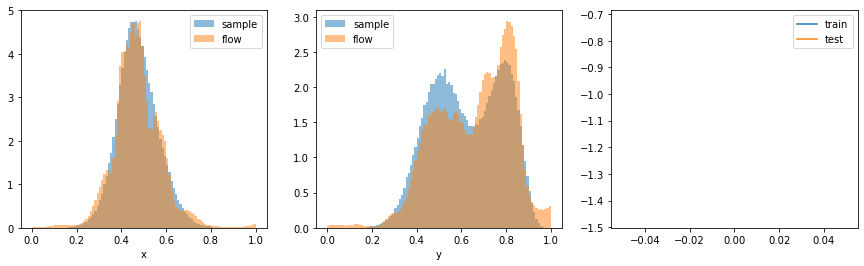

OutOfMemoryError: CUDA out of memory. Tried to allocate 92.00 MiB (GPU 0; 14.75 GiB total capacity; 13.54 GiB already allocated; 78.81 MiB free; 13.98 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [10]:
flow = make_flow_and_train(new_loader_train, new_loader_test, new_df_test)

## Apply it

In [ ]:
apply(flow, df_test, df_target_test)